In [1]:
import torch
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
from tqdm import tqdm
from skimage.metrics import structural_similarity as compute_ssim
import matplotlib.pyplot as plt
import seaborn as sns

## Prepare the Dataset

In [2]:
# Set the device to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the MNIST dataset and normalize the pixel values to the range [0, 1]
train_data = datasets.MNIST(root = ".", download = True, train = True, transform = ToTensor())
test_data = datasets.MNIST(root = ".", download = True, train = False, transform = ToTensor())
train_dataloader = DataLoader(train_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.17MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.9MB/s]


## Implement the Diffusion Model

In [3]:
# Noise generator to add Gaussian noise with varying standard deviations
def noise_generator(size, std):
  noise = torch.randn(size, device = std.device) * std
  return noise

In [4]:
# Define beta - how much noise is added at each time step
timestep = 100
beta = torch.linspace(0.0001, 0.02, timestep)

# Define alpha - how much image is preserved at each time step
alpha = 1.0 - beta

# Used for calulating forward diffusion process
alpha_cumprod = torch.cumprod(alpha, dim = 0)
signal_scaling = torch.sqrt(alpha_cumprod)
noise_scaling = torch.sqrt(1.0 - alpha_cumprod)

# Forward diffusion process to generate noisy images
def forward_diffusion(original_image, t):
  device = t.device
  batch_size = original_image.shape[0]
  noise_scaling_t = noise_scaling.to(device)[t].view(batch_size, 1, 1, 1)     # map the shape of [B, C, H, W]
  signal_scaling_t = signal_scaling.to(device)[t].view(batch_size, 1, 1, 1)
  noise = noise_generator(original_image.shape, noise_scaling_t)
  noisy_image = signal_scaling_t * original_image + noise_scaling_t * noise
  return noisy_image, noise

## Implement U-Net with Transformer

In [5]:
# Double convolution apply to downsampling and upsampling
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_ch),         # Normalizes the output
            nn.ReLU(inplace = True),          # ReLU activation
            nn.Conv2d(out_ch, out_ch, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace = True),
        )

    def forward(self, x):
        return self.conv(x)

# Downsampling path (encoder)
class DownSamp(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)         # Pooling to reduce image size
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        return self.conv(self.pool(x))

# Upsampling path (decoder)
class UpSamp(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.UpSamp = nn.ConvTranspose2d(in_ch, out_ch, 2, stride = 2)        # Compress back to the original image size
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x2 = self.UpSamp(x2)
        diffY = x1.size()[2] - x2.size()[2]         # Height difference
        diffX = x1.size()[3] - x2.size()[3]         # Weight difference
        # Calculate padding [left, right, top, bottom]
        x2 = F.pad(x2, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        # Skip connections
        x = torch.cat([x1, x2], dim = 1)
        return self.conv(x)

# U-Net Process with transformer applied
class UNet(nn.Module):
    def __init__(self, d_model = 256, num_heads = 4, ff_dim = 512, num_layers = 2, image_size = 28):
        super().__init__()
        # Encoder
        self.conv1 = DoubleConv(1, 64)
        self.down1 = DownSamp(64, 128)
        self.down2 = DownSamp(128, 256)

        self.pos_encoder = PositionalEncoding(d_model, max_len = image_size ** 2)       # Positional encoding to map pixel positions
        transform_layer = AttnTransformerLayer(d_model = d_model, nhead = num_heads, dim_feedforward = ff_dim)  # For attention tracking
        self.attention_tracker = transform_layer     # Used for attention map visualization
        # Transformer
        self.transformer = nn.TransformerEncoder(transform_layer, num_layers = num_layers)

        # Decoder
        self.up1 = UpSamp(256, 128)
        self.up2 = UpSamp(128, 64)
        self.last_conv = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        B, C, H, W = x.shape

        # Downsampling
        x1 = self.conv1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        # Bottleneck
        x3_flat = x3.view(B, -1, x3.shape[1])        # Flatten [B, C, H, W] to [B, N, C] where N = H * W
        x3_flat = x3_flat.permute(1, 0, 2)          # [N, B, C]
        x3_encoded = self.pos_encoder(x3_flat)          # Positional encoding to map pixel positions
        x3_transformed = self.transformer(x3_encoded)       # Transformer
        x3_transformed = x3_transformed.permute(1, 2, 0).view(B, -1, x3.shape[2], x3.shape[3])      # Reshape back to [B, C, H, W]
        # Upsamling
        x1_up = self.up1(x2, x3_transformed)
        x2_up = self.up2(x1, x1_up)
        # Output
        output = self.last_conv(x2_up)
        return output

In [6]:
# Positional Encoding for mapping the spatial location of features
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 1000):
        super().__init__()
        self.dropout = nn.Dropout(p = dropout)

        position = torch.arange(max_len).unsqueeze(1).float()   # Generate position indices
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # Calculate div_term with shape d_model // 2

        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)     # Sin for even indices
        pe[:, 0, 1::2] = torch.cos(position * div_term)     # Cos for odd indices

        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Transformer Encoder Layer to saves attention weights
class AttnTransformerLayer(nn.TransformerEncoderLayer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.attn_weights = None

    def forward(self, x, **kwargs):
        attn_out, attn_weights = self.self_attn(x, x, x, need_weights = True)   # Multihead attention
        self.attn_weights = attn_weights
        x = self.norm1(x + self.dropout1(attn_out))     # Feedforward network
        attn_out = self.linear2(self.dropout(self.activation(self.linear1(x))))
        x = self.norm2(x + self.dropout2(attn_out))
        return x

## Training and Testing

In [7]:
# Train diffusion process + Transformer on the noisy MNIST dataset
def trainer(model, optimizer, train_loader, test_loader, criterion, epochs = 5, device = "cpu", verbose = True):
    model.to(device)
    model.train()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_count = 0

        # Training loop
        for images, _ in tqdm(train_dataloader, desc = f"Training {epoch + 1}/{epochs}"):
            images = images.to(device)

            batch_size = images.shape[0]
            t = torch.randint(0, timestep, (batch_size,))      # Select random timestep
            t = t.to(device)

            noisy_image, noise = forward_diffusion(images, t)       # Get noisy image by diffusion
            noise_pred = model(noisy_image)       # Model prediction on noise
            loss = criterion(noise_pred, noise)         # Calculate loss

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_count += batch_size

            total_loss += loss.item()
        avg_loss =  total_loss / len(train_dataloader)       # Calculate average loss

        # Evaluate the model on unseen noisy data
        model.eval()
        total_mse = 0
        total_ssim = 0
        test_count = 0

        with torch.no_grad():
            for images, _ in tqdm(test_dataloader, desc = f"Testing Epoch {epoch + 1}/{epochs}"):
                images = images.to(device)
                batch_size = images.shape[0]

                # Add noise in the middle of full time step to test moderate noise removal
                mid_step = timestep // 2
                t = torch.full((batch_size,), mid_step)
                t = t.to(device)

                noisy_images, _ = forward_diffusion(images, t)
                pred_noise = model(noisy_images)        # Model predict noise
                # Denoise with reverse diffusion process
                scaling = noise_scaling.to(t.device)[t] / signal_scaling.to(t.device)[t]
                denoised_images = noisy_images - pred_noise * scaling.view(-1, 1, 1, 1)

                test_count += batch_size

                # Calculate evaluation metrics
                total_mse += calculate_mse(images, denoised_images) * batch_size
                total_ssim += calculate_ssim(images, denoised_images) * batch_size

        avg_mse = total_mse / test_count         # Calculate average metrics
        avg_ssim = total_ssim / test_count

        if verbose:
            print(f"\nMSE: {avg_mse:.4f} ; SSIM: {avg_ssim:.4f}\n")

# Calculate mean squared error for batch
def calculate_mse(original, reconstructed):
    return ((original - reconstructed) ** 2).mean(dim = (1, 2, 3)).mean().item()

# Calculate similarity index measure for batch
def calculate_ssim(original_batch, reconstructed_batch):
    total_ssim = 0
    batch_size = original_batch.size(0)

    for i in range(batch_size):
        original = original_batch[i].squeeze().cpu().numpy()
        reconstructed = reconstructed_batch[i].squeeze().cpu().numpy()
        total_ssim += compute_ssim(original, reconstructed, data_range = original.max() - original.min())

    return total_ssim / batch_size

In [8]:
# Call training loop
model = UNet().to(device)         # Initialize UNet model
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
num_epochs = 50         # Train the model for 50–100 epochs
criterion = nn.MSELoss()

trainer(
    model = model,
    optimizer = optimizer,
    train_loader = train_dataloader,
    test_loader = test_dataloader,
    criterion = criterion,
    epochs = num_epochs,
    device = device
)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Testing Epoch 1/50: 100%|██████████| 157/157 [00:05<00:00, 28.86it/s]



MSE: 0.0067 ; SSIM: 0.7634



Testing Epoch 2/50: 100%|██████████| 157/157 [00:05<00:00, 29.40it/s]



MSE: 0.0069 ; SSIM: 0.7568



Testing Epoch 3/50: 100%|██████████| 157/157 [00:05<00:00, 29.71it/s]



MSE: 0.0061 ; SSIM: 0.7748



Testing Epoch 4/50: 100%|██████████| 157/157 [00:05<00:00, 29.78it/s]



MSE: 0.0066 ; SSIM: 0.7638



Testing Epoch 5/50: 100%|██████████| 157/157 [00:05<00:00, 29.78it/s]



MSE: 0.0065 ; SSIM: 0.7844



Testing Epoch 6/50: 100%|██████████| 157/157 [00:05<00:00, 29.64it/s]



MSE: 0.0059 ; SSIM: 0.7667



Testing Epoch 7/50: 100%|██████████| 157/157 [00:05<00:00, 29.09it/s]



MSE: 0.0059 ; SSIM: 0.7865



Testing Epoch 8/50: 100%|██████████| 157/157 [00:05<00:00, 29.13it/s]



MSE: 0.0060 ; SSIM: 0.7875



Testing Epoch 9/50: 100%|██████████| 157/157 [00:05<00:00, 29.23it/s]



MSE: 0.0059 ; SSIM: 0.7986



Testing Epoch 10/50: 100%|██████████| 157/157 [00:05<00:00, 29.63it/s]



MSE: 0.0060 ; SSIM: 0.7863



Testing Epoch 11/50: 100%|██████████| 157/157 [00:05<00:00, 29.84it/s]



MSE: 0.0060 ; SSIM: 0.7899



Testing Epoch 12/50: 100%|██████████| 157/157 [00:05<00:00, 29.37it/s]



MSE: 0.0063 ; SSIM: 0.7963



Testing Epoch 13/50: 100%|██████████| 157/157 [00:05<00:00, 29.75it/s]



MSE: 0.0060 ; SSIM: 0.8039



Testing Epoch 14/50: 100%|██████████| 157/157 [00:05<00:00, 28.92it/s]



MSE: 0.0059 ; SSIM: 0.7778



Testing Epoch 15/50: 100%|██████████| 157/157 [00:05<00:00, 29.64it/s]



MSE: 0.0059 ; SSIM: 0.7964



Testing Epoch 16/50: 100%|██████████| 157/157 [00:05<00:00, 29.62it/s]



MSE: 0.0062 ; SSIM: 0.7939



Testing Epoch 17/50: 100%|██████████| 157/157 [00:05<00:00, 29.56it/s]



MSE: 0.0058 ; SSIM: 0.7964



Testing Epoch 18/50: 100%|██████████| 157/157 [00:05<00:00, 29.41it/s]



MSE: 0.0058 ; SSIM: 0.7873



Testing Epoch 19/50: 100%|██████████| 157/157 [00:05<00:00, 29.41it/s]



MSE: 0.0060 ; SSIM: 0.7837



Testing Epoch 20/50: 100%|██████████| 157/157 [00:05<00:00, 29.19it/s]



MSE: 0.0062 ; SSIM: 0.7792



Testing Epoch 21/50: 100%|██████████| 157/157 [00:05<00:00, 29.15it/s]



MSE: 0.0060 ; SSIM: 0.7721



Testing Epoch 22/50: 100%|██████████| 157/157 [00:05<00:00, 29.42it/s]



MSE: 0.0058 ; SSIM: 0.7785



Testing Epoch 23/50: 100%|██████████| 157/157 [00:05<00:00, 29.52it/s]



MSE: 0.0057 ; SSIM: 0.8083



Testing Epoch 24/50: 100%|██████████| 157/157 [00:05<00:00, 29.54it/s]



MSE: 0.0059 ; SSIM: 0.7896



Testing Epoch 25/50: 100%|██████████| 157/157 [00:05<00:00, 28.73it/s]



MSE: 0.0058 ; SSIM: 0.8045



Testing Epoch 26/50: 100%|██████████| 157/157 [00:05<00:00, 29.22it/s]



MSE: 0.0058 ; SSIM: 0.7966



Testing Epoch 27/50: 100%|██████████| 157/157 [00:05<00:00, 29.42it/s]



MSE: 0.0059 ; SSIM: 0.7873



Testing Epoch 28/50: 100%|██████████| 157/157 [00:05<00:00, 29.25it/s]



MSE: 0.0056 ; SSIM: 0.8051



Testing Epoch 29/50: 100%|██████████| 157/157 [00:05<00:00, 29.44it/s]



MSE: 0.0061 ; SSIM: 0.7925



Testing Epoch 30/50: 100%|██████████| 157/157 [00:05<00:00, 28.91it/s]



MSE: 0.0055 ; SSIM: 0.7825



Testing Epoch 31/50: 100%|██████████| 157/157 [00:05<00:00, 28.49it/s]



MSE: 0.0058 ; SSIM: 0.7803



Testing Epoch 32/50: 100%|██████████| 157/157 [00:05<00:00, 28.31it/s]



MSE: 0.0057 ; SSIM: 0.7989



Testing Epoch 33/50: 100%|██████████| 157/157 [00:05<00:00, 29.06it/s]



MSE: 0.0055 ; SSIM: 0.8053



Testing Epoch 34/50: 100%|██████████| 157/157 [00:05<00:00, 29.01it/s]



MSE: 0.0058 ; SSIM: 0.7970



Testing Epoch 35/50: 100%|██████████| 157/157 [00:05<00:00, 28.97it/s]



MSE: 0.0059 ; SSIM: 0.7757



Testing Epoch 36/50: 100%|██████████| 157/157 [00:05<00:00, 29.03it/s]



MSE: 0.0059 ; SSIM: 0.7840



Testing Epoch 37/50: 100%|██████████| 157/157 [00:05<00:00, 28.84it/s]



MSE: 0.0058 ; SSIM: 0.7899



Testing Epoch 38/50: 100%|██████████| 157/157 [00:05<00:00, 28.71it/s]



MSE: 0.0058 ; SSIM: 0.7965



Testing Epoch 39/50: 100%|██████████| 157/157 [00:05<00:00, 28.34it/s]



MSE: 0.0056 ; SSIM: 0.7988



Testing Epoch 40/50: 100%|██████████| 157/157 [00:05<00:00, 29.03it/s]



MSE: 0.0059 ; SSIM: 0.7902



Testing Epoch 41/50: 100%|██████████| 157/157 [00:05<00:00, 28.89it/s]



MSE: 0.0053 ; SSIM: 0.8062



Testing Epoch 42/50: 100%|██████████| 157/157 [00:05<00:00, 28.69it/s]



MSE: 0.0057 ; SSIM: 0.7900



Testing Epoch 43/50: 100%|██████████| 157/157 [00:05<00:00, 28.40it/s]



MSE: 0.0057 ; SSIM: 0.7977



Testing Epoch 44/50: 100%|██████████| 157/157 [00:05<00:00, 29.05it/s]



MSE: 0.0056 ; SSIM: 0.7924



Testing Epoch 45/50: 100%|██████████| 157/157 [00:05<00:00, 28.79it/s]



MSE: 0.0056 ; SSIM: 0.7920



Testing Epoch 46/50: 100%|██████████| 157/157 [00:05<00:00, 29.19it/s]



MSE: 0.0058 ; SSIM: 0.7927



Testing Epoch 47/50: 100%|██████████| 157/157 [00:05<00:00, 28.97it/s]



MSE: 0.0060 ; SSIM: 0.7661



Testing Epoch 48/50: 100%|██████████| 157/157 [00:05<00:00, 29.13it/s]



MSE: 0.0056 ; SSIM: 0.7894



Testing Epoch 49/50: 100%|██████████| 157/157 [00:05<00:00, 28.73it/s]



MSE: 0.0058 ; SSIM: 0.7989



Testing Epoch 50/50: 100%|██████████| 157/157 [00:05<00:00, 28.47it/s]


MSE: 0.0058 ; SSIM: 0.7760



In [ ]:
# Save and load the trained model to prevent re-training
torch.save(model.state_dict(), "trained_model.pt")
model = UNet().to(device)
model.load_state_dict(torch.load("trained_model.pt", map_location = device))
model.eval()

## Visualisation

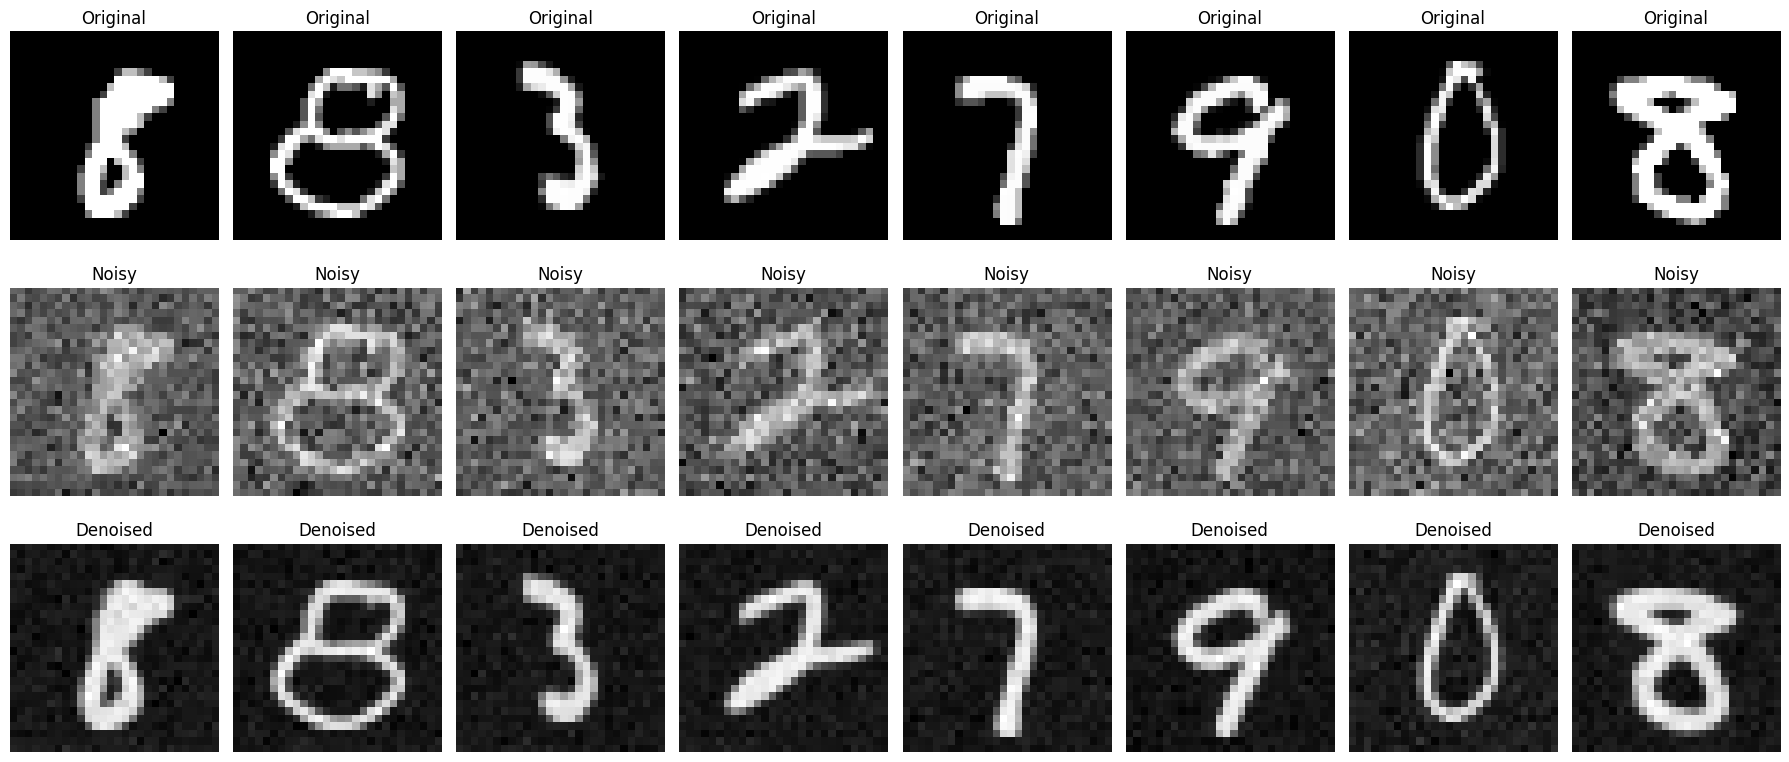

In [10]:
# Plot examples of noisy images and their corresponding denoised outputs
model.eval()
images, _ = next(iter(test_dataloader))     # Get a batch of test images
images = images.to(device)

# Add noise at midpoint
mid_step = timestep // 2
t = torch.full((images.shape[0],), mid_step, device = device, dtype = torch.long)
noisy_images, _ = forward_diffusion(images, t)

# Predict noise added in diffusion
pred_noise = model(noisy_images)

# Reconstruct denoised image with scaling parameters
scaling = noise_scaling.to(t.device)[t] / signal_scaling.to(t.device)[t]
denoised_images = noisy_images - pred_noise * scaling.view(-1, 1, 1, 1)

# Plot results
num_examples = 8
plt.figure(figsize = (18, 8))

for i in range(num_examples):
    # Original image
    plt.subplot(3, num_examples, i + 1)
    plt.imshow(images[i].squeeze().cpu(), cmap = "gray")
    plt.title("Original")
    plt.axis("off")

    # Noisy image
    plt.subplot(3, num_examples, num_examples + i + 1)
    plt.imshow(noisy_images[i].squeeze().cpu(), cmap = "gray")
    plt.title("Noisy")
    plt.axis("off")

    # Denoised image
    plt.subplot(3, num_examples, 2 * num_examples + i + 1)
    plt.imshow(denoised_images[i].squeeze().detach().cpu().numpy(), cmap = "gray")
    plt.title("Denoised")
    plt.axis("off")

plt.tight_layout()
plt.show()

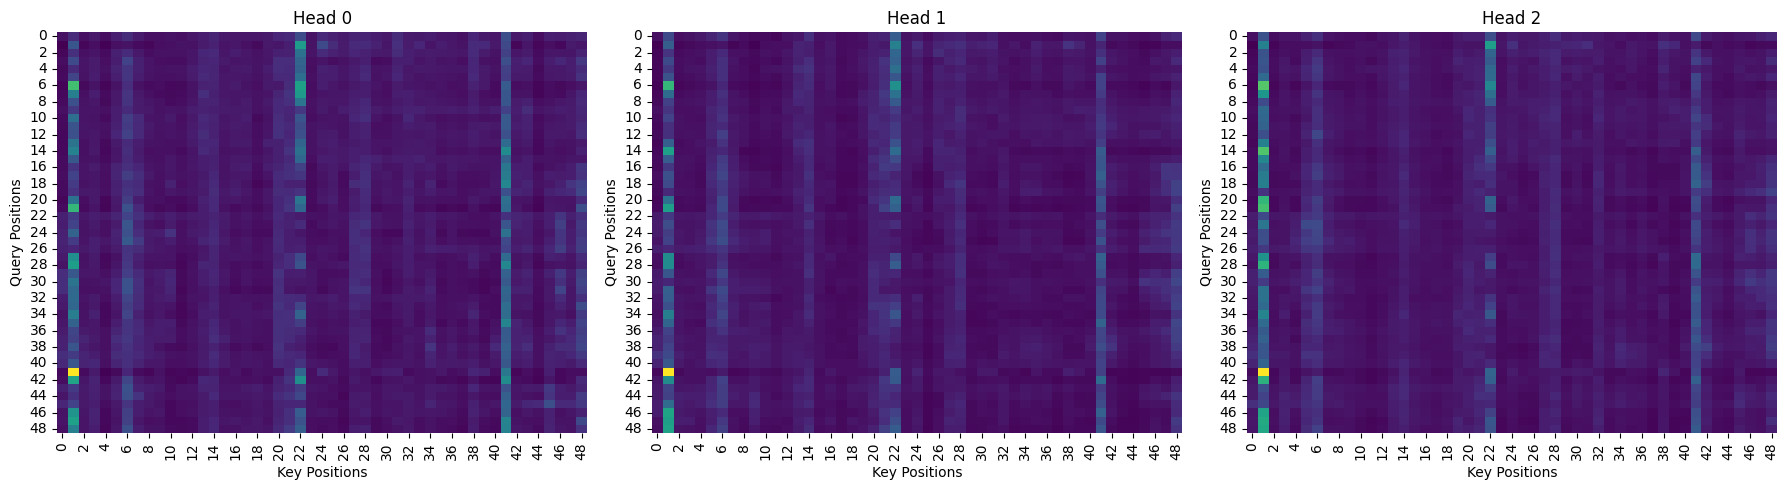

In [11]:
# Visualize attention maps from the Transformer module (for multiple heads)
images, _ = next(iter(test_dataloader))
_ = model(images.to(device))

# Extract attention weights from first transformer layer
attn_weights = model.transformer.layers[0].attn_weights
attn_weights = attn_weights.squeeze().detach().cpu()

plt.figure(figsize=(18, 5))

# Head 0
plt.subplot(1, 3, 1)
sns.heatmap(attn_weights[0], cmap="viridis", cbar=False)
plt.title("Head 0")
plt.xlabel("Key Positions")
plt.ylabel("Query Positions")

# Head 1
plt.subplot(1, 3, 2)
sns.heatmap(attn_weights[1], cmap="viridis", cbar=False)
plt.title("Head 1")
plt.xlabel("Key Positions")
plt.ylabel("Query Positions")

# Head 2
plt.subplot(1, 3, 3)
sns.heatmap(attn_weights[2], cmap="viridis", cbar=False)
plt.title("Head 2")
plt.xlabel("Key Positions")
plt.ylabel("Query Positions")

plt.tight_layout()
plt.show()